<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Tuesday 31 January 2017</td>
<td style="text-align: right;"><a href="https://github.com/douglask3/amazon_fires">github.com/douglask3/amazon_fires</td>
</tr>
</table>

<div>
<center>
<font face="Times">
<br>
<h1>Unusual fire seasons in a changing climate - A Bayesian approach</h1>
<br>
<br>
<sup>1,* </sup> Douglas Ian Kelley,
<sup>2 </sup>Chantelle Burton, 
<sup>3 </sup>Rhys Whitley,
<sup>1 </sup>Chris Huntingford,
<sup>4 </sup>Ioannis Bistinas, 
<sup>1,5 </sup>Megan Brown, 
<sup>6 </sup>Ning Dong, 
<sup>1 </sup>Toby R. Marthews
<br>
<br>
<br>
<sup>*  </sup> douglas.i.kelley@gmail.com
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Met Office United Kingdom, Exeter, United Kingdom
<br>
<sup>3 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<sup>4 </sup>ATOS Nederland B.V., Amstelveen, The Netherlands
<br>
<sup>5 </sup>School of Physical Sciences, The Open University, Milton Keynes, UK
<br>
<sup>6 </sup>Department of Biological Sciences, Macquarie University, North Ryde, NSW 2109, Australia 
<br>
<br>
<h3>Abstract</h3>
<hr>
<p> 
This notebook aims to quantify the model parameters of the ConFire model, defined below. The model is driven by a number of covariates (X<sub>i=1, 2, ... M</sub>) that describe: agricultural footprints; frequency of lightning ignitions, population density, vegetation cover, soil moisture at atmospheric drying potential. The model attempts to predict the impact of fire through burnt area and is thus the model target (Y).
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

### Setup
Lets import the librarys and set plotting styles:

In [112]:
import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import pymc3  as pm3 
from   pymc3.backends import SQLite
from   scipy  import optimize
from   theano import tensor as tt

import matplotlib.pyplot as plt
import re
import corner  # https://corner.readthedocs.io

# setup nice plotting
plt.style.use('ggplot')
%matplotlib inline

These paths are for input data (```datPath```), made using the previous prepare_data.ipynb notebook, and the resultant parameter distribution (```param_outpath```) which we'll need when we run ```make_model_output.ipynb``` next.

In [113]:
datPath       = "../inputs/amazon_inference_data-2002-MCDBA_obs-TERRA_M__T.csv"
param_outpath = '../outputs/params-for_sampling_logitnorm_long_PAdd_PT.csv'

### Model description
Here is a brief model outline for the sake of comprehension of this notebook. The science behind each of these drivers can be found in the companion papers. Kelley et al. 2019 can be found here [https://rdcu.be/bO6ey](https://rdcu.be/bO6ey). The paper specific to Amazon fires should be available soon.
 
 The model considers fractional burnt area to be the joint product of a set of conditions that modulate fire through fuel load, ignitions, moisture and suppression. Each control assumes some equilibrium point that describes the optimal conditions for fire, that may be proportionally modified through some empirical relationship.

\begin{eqnarray}
    F_{burn} &=& F_{max} \cdot \prod_{i}S(x_{i}) \\[1em]
\end{eqnarray}

Where $S(x_{i})$ representes some measure of fire conditions by $i =$ fuel, moisture, ignitions and anthropagenic supression, and is describe by a sigmoid:

\begin{equation}
    S(x_{i=fuel, moist, ignite, suppr}) = \frac{1}{1 + \exp\{-k_i\cdot(x_i-x_{0,i})\}}
\end{equation}

The $fuel$ sigmoid considers fractional vegetation cover and seasonal fuel ``flushing''. Sigmoids $moist$, $ignite$ and $suppr$ describe an aggregation of other climate and land-use covariates. Because these sigmoids are influenced by an aggregation of different drivers, they are influenced in turn by different sets of hyper-parameters; these are now described below.  

#### Fuel load covariate (no hyper-parameters)
\begin{equation}
    x_{fuel} = FPC^{p} \cdot (v_{fuel} \cdot (\alpha_{max}/\alpha_{mean} -1) + 1)/(1+v_{fuel}) 
\end{equation}

#### Moisture covariate
\begin{equation}
    x_{moist} = (\alpha_{shallow} + v_{deep} \cdot \alpha_{deep} + v_M \cdot EMC_{*} + v_{tree} \cdot FPC_{tree}) / (1 + v_{deep} + v_M + v_{tree})
\end{equation}
\begin{equation}
    EMC_* = WD + (1-WD) * ECM
\end{equation}
\begin{equation}
    WD = 1 - e^{\tau * precip}
\end{equation}

where $WD$ is a proxy for wet days and $EMC$ is the equilibrium moisture content.
#### Ignition covariate 
\begin{equation}
    x_{ignite} = (Lightn + v_p \cdot A_{pasture} + v_{d1}\cdot\rho_{population}) / (1 + v_p + v_{d1})
\end{equation}

Where $Lightn$ is the number of cloud-to-ground lightning strikes, modified as per Kelley et al. 2014.

#### Supression covariate 
\begin{equation}
    x_{supress} = (A_{urban} + v_C\cdot A_{Crop} + v_{d2}\cdot\rho_{population} ) / (1 + v_C + v_{d2})
\end{equation}

This leaves 19 free parameters $\{F_{max}, \{k_i\}, \{x_{0, i}\}, p, v_{fuel}, v_{deep}, v_M, v_{tree}, \tau, v_p, v_{d1}, v_C, v_{d2}\}$ that need to be optimised against observations of burnt area.  


## 2.1 Fire limitation model definition

Could possibly contain this in a class object, but I'm not sure theano can instantiate the object to be used by the GPU. If I've made absolutely no sense just then, then I would leave the following as is.

In [114]:
from pdb import set_trace as browser
def fuel_load(vegcover, soilwMax, fuel_pw, fuel_pg):
    """
    Definition to describe fuel load: while return the input; capability to be modified later.
    """
  
    return (vegcover**fuel_pw) * (fuel_pg * (soilwMax-1) + 1) / (1 + fuel_pg)

def emc_weighted(emc, precip, wd_pg):
    wet_days = 1 - tt.exp(-wd_pg * precip)
    
    emcw = wet_days + (1-wet_days) * emc
    
    return(emcw)
    
    
def moisture(shallow_soilw, deep_soilw, emcw, treeCover, cMs, cM, cMT, kM, pT):
    """
    Definition to describe moisture
    """
    moist = (shallow_soilw + cMs * deep_soilw + cM*emcw + cMT * (treeCover**pT)) / (1 + cM + cMs + cMT)
    moist = 1 - tt.log(1 - moist*kM)
    return moist


def ignition(lightning, pasture, population_density, cP, cD1):
    """
    Definition for the measure of ignition
    """
    ignite = lightning + cP*pasture + cD1*population_density
    #ignite = tt.log(ignite)
    return ignite

def supression(cropland, population_density, cD2):
    """
    Definition for the measure of fire supression
    """
    return cropland + cD2*population_density

def tt_sigmoid(x, k, x0):
    """
    Sigmoid function to describe limitation using tensor
    """
    return 1.0/(1.0 + tt.exp(-k*(x - x0)))

## 2.2 Import data

Load data and do any necessary transformation needed for the Bayesian modelling framework. Rows are defined as a fraction of total data points (above). For full optimization, we set at 100%, but for testing purposes, I've limited the number of rows to 10% and still got vaguely sensible test results.


In [115]:
                   # Full optiomization recomentations in comments. These can be reduced to test things out though
sample_pc     = 100 # = 100 # Percentage of grid cells samples (largest = 100%) - training set

In [116]:
def load_with_buffer(filename, line_select, **kwargs):
    s_buf = StringIO()
    line_select = np.sort(line_select)
    with open(filename) as file:
        count = -1
        lineN = -1
        for line in file:
            lineN += 1
            if lineN == 0 or lineN == line_select[count]:
                s_buf.write(line)
                
                count += 1
                if count == len(line_select): break
            
    s_buf.seek(0)
    df = pd.read_csv(s_buf,**kwargs)
    return df

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f): pass
    return i + 1

DATAPATH = os.path.expanduser(datPath)

nlines      = file_len(DATAPATH)
npoints     = round(sample_pc * nlines / 100)
line_select = np.random.choice(range(0, nlines), npoints, False)
line_select = line_select[line_select > 0]
fd          = load_with_buffer(DATAPATH, line_select)


Do a sanity check to make sure our data has imported correctly.

In [117]:
fd.head()

,air,emc,lightning,relative_humidity,tasMax_,precip,seasonDiff,soilw,deep_soilw,shallow_soilw,...,cropland,fract_agr,pasture,population_density,dt_cropland,dt_fract_agr,dt_pasture,dt,dt.1,dt.2
0,27.087145,0.205117,117.581160,69.133930,304.15714,0.575250,1.003373,0.277269,0.117291,0.277269,...,0.075360,0.586741,0.511381,55.566036,0.000075,0.005090,0.005015,0.000075,0.005090,0.005015
1,25.412504,0.186246,126.675490,59.910713,303.41430,0.670358,1.007553,0.064362,0.000000,0.064362,...,0.084143,0.447438,0.363295,62.798744,0.000132,0.003784,0.003653,0.000132,0.003784,0.003653
2,26.206789,0.175376,41.093647,56.357143,303.63570,0.183623,0.977350,0.000000,0.000000,0.000000,...,0.097023,0.220080,0.123057,60.748290,-0.000030,0.000290,0.000320,-0.000030,0.000290,0.000320
3,26.552143,0.181388,1.843172,59.107143,303.47858,0.547380,0.961316,0.000000,0.000000,0.000000,...,0.062484,0.196809,0.134325,102.104780,-0.000024,0.000885,0.000909,-0.000024,0.000885,0.000909
4,25.338928,0.216764,5.154491,72.044640,302.51070,0.491154,1.030102,0.067631,0.000000,0.067631,...,0.044306,0.165909,0.121603,44.035473,-0.000038,0.000417,0.000455,-0.000038,0.000417,0.000455


## 2.3 Bayesian framework

A simple explanation of Baye's law is:

\begin{equation}
    P(\beta|X) \propto P(\beta)\cdot P(X|\beta)
\end{equation}

where $X$ is our data (observations of some arbitrary system), and $\beta$ our set of unexplained parameters that describe the response of our _proposed understanding_ of this system as it varies with $X$.

### 2.3.1 Prior definitions
Because I have no idea what the uncertainty on the hyperparameters should look like (beyond, say $\beta_i> 0$), I've made the priors as uninformed as possible, with distributions determined by physical bounds of the variable in question, or set generously beyond what is realistically plausible. Some of them could have more information or distributions based on updated qualitative knowledge of the bounds, but we can play around with that later.

\begin{eqnarray}
    P(\beta) &=& \prod_{i=1}^{4}P(a_i)\prod_{i=1}^{4}P(b_i)\cdot P(\sigma)\cdot P(v_c)P(v_p)P(v_{d,1})P(v_{d,2}) \\[1.5em]
    P(a) = P(b) = P(\sigma) &=& \mathcal{N}(0, 1) \\[1em]
    P(v_c) = P(v_p) = P(v_{d,1}) = P(v_{d,2}) &=& \mathcal{U}(\beta_{\min}, \beta_{\max}) \\[1.5em]
\end{eqnarray}

I'm not totally sure about the maths above being right, but it's just to show that a normal assumption for _full_ prior isn't crazy. Important, because we'll also describe the error (likelihood) as normal, such that the posterior is therefore normal (conjugate); i.e. $\mathcal{N}\times\mathcal{N}=\mathcal{N}$ (expansion happens in the mean of the exponent). In reality, the model could be better approximated with something a little cleverer than a normal distribution... but all our attempts at designing this so far have made convergence screwy. Again, more play required here.

Back to the code.., `pymc3` is quite funky in that it allows me to create an empty `Model()` object and just add things to it as I need them using a `with` statement. I've called our Bayesian model `fire_error` as that is what we are trying to Quantify.


In [118]:
with pm3.Model() as fire_error:

# first for the sigmoids  
    fuel_x0        = pm3.Normal     ('fuel_x0'     , 0.5, 0.25)
    fuel_k         = pm3.Exponential('fuel_k'      , 1.0      ) 
    fuel_pw        = pm3.Exponential('fuel_pw'     , 1.0      )
    fuel_pg        = pm3.Uniform('fuel_pg'         , 0.0, 1.0 )

    moisture_x0    = pm3.Normal     ('moisture_x0', 0.5, 0.25)
    moisture_k     = pm3.Exponential('moisture_k'  , 1.0     )
    wd_pg          = pm3.Exponential('wd_pg'  , 1.0     )

    ignition_x0    = pm3.Normal     ('ignition_x0', 1000.0, 50.0)
    ignition_k     = pm3.Exponential('ignition_k' , 100.0     )

    suppression_x0 = pm3.Normal ('suppression_x0'  , 0.5, 0.25)
    suppression_k  = pm3.Exponential('suppression_k', 1.0     ) 

    max_f          = pm3.Uniform('max_f'           , 0.0, 1.0)
    #exp_scale      = pm3.Exponential('exp_scale'   , 1.0     )        
        
# now for the hyper-parameters that describe the independent fire condition covariates
    cM  = pm3.Exponential('cM' , 1.0)
    cMs = pm3.Exponential('cMs', 1.0)
    cMT = pm3.Exponential('cMT', 1.0)
    cP  = pm3.Exponential('cP' , 1.0)
    cD1 = pm3.Exponential('cD1', 1.0)
    cD2 = pm3.Exponential('cD2', 1.0)
    kM  = pm3.LogitNormal('kM' , 0.0, 1.0)
    pT  = pm3.Lognormal('pT', 0.0, 1.0)
    
    #p0 = pm3.Exponential('p0', 1.0)
    p0 = pm3.Uniform('p0', 0.0, 1.0)
    pp = pm3.Lognormal('pp', 0.0, 1.0)
        
# describe the standard deviation in the error term
    sigma = pm3.HalfNormal('sigma', sd=0.1)

### 2.3.2 Likelihood definition

For the sake of simplicity (and because I don't really know any better), we define the model error as normally distributed (i.i.d.) although it most likely isn't. We could make this more complicated later by defining the error as heteroscedastic, but I wouldn't bother with that until we have some idea of the convergence. We're describing the error (observations minus model predictions) as follows:

\begin{eqnarray}
    P(X|\beta) &=& \mathcal{N}(F_{burn}, \sigma) \\[1em]
    \mathcal{N}(F_{burn}, \sigma) &=& \frac{N}{\sigma\sqrt{2\pi}}\exp\left\{\sum_{i=1}^{N}\left(\frac{y_i - F_{burn, i}}{\sigma_i}\right)^2\right\}
\end{eqnarray}

where $y_i$ is a set of observations we're attempting to optimise on. Below is the code that describes the above:

(array([26889.,  3544.,  2591.,  1414.,  1785.,  1697.,  1422.,  2191.,
         2819.,   398.]),
 array([2.01165676e-10, 5.18023470e-02, 1.03604694e-01, 1.55407041e-01,
        2.07209387e-01, 2.59011734e-01, 3.10814081e-01, 3.62616428e-01,
        4.14418774e-01, 4.66221121e-01, 5.18023468e-01]),
 <a list of 10 Patch objects>)

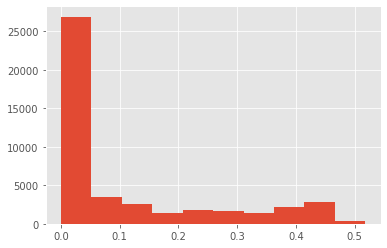

In [121]:
plt.hist(fd["treecover"].values**3.0)

In [122]:
def npLogit(x):
    return np.log(x/(1-x))
    
def ttLogit(x):
    return tt.log(x/(1-x))



In [123]:
obs = fd["burnt_area_MCD"].values
obs = npLogit(obs)
obs[obs < -31]  = -31
import math

def make_zero_inflated_normal(mu, sigma, pz, x):
    '''return tt.sw1itch(
        tt.lt(x, -150),
        -p0,
        -(1.0 - p0) *(1.0/(sigma * 2.506))*tt.exp(-0.5 * ((x-mu)/sigma)**2)
    )
    '''
    return tt.switch(
        tt.lt(x, -30),
        tt.log(pz),
        tt.log(1-pz) - tt.log(sigma * tt.sqrt(2*math.pi)) - ((x-mu)**2)/(2*sigma**2)
    )

In [124]:
with fire_error:
    # transform hyper-covariates 
    f_fuel        = fuel_load(fd["vegcover"].values, fd["MaxOverMean_soilw"].values, fuel_pw + 1.0, fuel_pg)

    emc_w         = emc_weighted(fd["emc"].values, fd["precip"].values, wd_pg)

    f_moisture    = moisture(fd["shallow_soilw"].values, fd["deep_soilw"].values, 
                             emc_w, fd["treecover"].values, cMs, cM, cMT, kM, pT)

    f_ignition    = ignition(fd["lightning"].values, \
                             fd["pasture"].values, \
                             fd["population_density"].values, \
                             cP, cD1)
    #f_ignition   = np.log(f_ignition)
    f_suppression = supression(fd["cropland"].values, \
                               fd["population_density"].values, \
                               cD2)

    # burnt area is assumed to be the product of the 4 sigmoids

    prediction = max_f * np.product([tt_sigmoid(f_fuel, fuel_k, fuel_x0),
                             tt_sigmoid(f_moisture, - moisture_k, moisture_x0),
                             tt_sigmoid(f_ignition, ignition_k, ignition_x0),
                             tt_sigmoid(f_suppression, - suppression_k, suppression_x0)])
    
    pz = 1.0 - (prediction**pp) * (1.0 - p0)
    prediction = ttLogit(prediction)
    
    #error1 = pm3.TruncatedNormal('error1', mu=prediction, sd=sigma, observed=fd["burnt_area_MCD"].values,
    #                            lower = 0.0, upper = 1.0)
    error = pm3.DensityDist("error", make_zero_inflated_normal,
                            observed = {"mu": prediction, "sigma": sigma, "pz": pz, "x": obs})

(array([   59.,    95.,   182.,   288.,   398.,   281.,   395.,   546.,
         1115., 41391.]),
 array([0.97285538, 0.97556984, 0.9782843 , 0.98099877, 0.98371323,
        0.98642769, 0.98914215, 0.99185661, 0.99457108, 0.99728554,
        1.        ]),
 <a list of 10 Patch objects>)

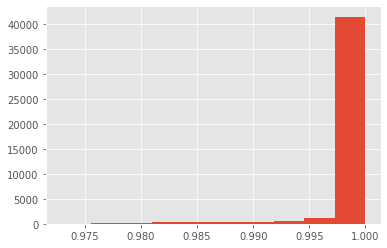

In [125]:
plt.hist(pz.tag.test_value)
#plt.plot(obs,prediction.tag.test_value, '.')
#obs[obs < -150]  = -150
#plt.hist(obs)
#plt.hist(prediction.tag.test_value)
#np.sum(make_zero_inflated_normal(prediction, sigma, p0, obs).tag.test_value)
#error1.tag.test_value

### 2.3.3 Posterior sampling

Because it is nigh impossible to determine the posterior solution analytically we will instead sample the information space to **infer** the posterior solutions for each of the model parameters. In this case, we are using a Metropolis-Hasting step MCMC.

I've tried using No-U-Turn (NUTS) sampling (which is the new kid on the block), but there are issues with it's current implementation in pymc3 (see github repo issues). Can use it once problems are ironed out (and as it's been a couple of years since this bit was written, many are probably fixed by now) - but TBH it doesn't matter if we're getting a reasonable convergence.

The Metropolis-Hasting step MCMC is set by ```pm3.Metropolis()``` and sampling information is passed to ```pm3.sample```. The first argument is the number of iterations. 1000 should be okay to see if the samplers doing something sensible. 10,000 should be enough iteration to do quick rough tests of the model posterior. For full and safe (and publishable) results, best set to 100,000, though even for this, you should check trace convergence to make sure you have enough effective samples. If not, you might need up to 1,000,000+. The number of ```chains``` basically says how many times to run the sampler... important incase our MCMC technique gets "stuck" somewhere. For playing with, this doesn’t need to be particularly high, though I've set this at 10 to play it safe.



In [126]:
nChains = 10
with fire_error:
    # help the sampling out by quickly finding an optimal start position. Not vita, and wont work on all systems,
    #start = pm3.find_MAP(draws = 10000, model=fire_error.model, fmin=optimize.fmin_powell)

    # set the step-method (criteria algorithm for moving around information space)        
    step = pm3.Metropolis()

    # save our sampling to disk so we can access it later. Again, not vital and wont work on all systems.
    #db_save = SQLite("../temp/firemodel_trace.db")

    # do the sampling
    mcmc_traces = pm3.sample(10000, step=step, chains = nChains) #, start=start, trace=db_save
    

Multiprocess sampling (10 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (10 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [sigma]
INFO:pymc3:>Metropolis: [sigma]
>Metropolis: [pp]
INFO:pymc3:>Metropolis: [pp]
>Metropolis: [p0]
INFO:pymc3:>Metropolis: [p0]
>Metropolis: [pT]
INFO:pymc3:>Metropolis: [pT]
>Metropolis: [kM]
INFO:pymc3:>Metropolis: [kM]
>Metropolis: [cD2]
INFO:pymc3:>Metropolis: [cD2]
>Metropolis: [cD1]
INFO:pymc3:>Metropolis: [cD1]
>Metropolis: [cP]
INFO:pymc3:>Metropolis: [cP]
>Metropolis: [cMT]
INFO:pymc3:>Metropolis: [cMT]
>Metropolis: [cMs]
INFO:pymc3:>Metropolis: [cMs]
>Metropolis: [cM]
INFO:pymc3:>Metropolis: [cM]
>Metropolis: [max_f]
INFO:pymc3:>Metropolis: [max_f]
>Metropolis: [suppression_k]
INFO:pymc3:>Metropolis: [suppression_k]
>Metropolis: [suppression_x0]
INFO:pymc3:>Metropolis: [suppression_x0]
>Metropolis: [ignition_k]
INFO:pymc3:>Metropolis: [ignition_k]
>Metropolis: [ignition_x0]
INFO:pymc3:>Metropolis: [ignition_x0]
>Metropolis:

### Plotting

So let's just have a look at what happened here. To start with, some of the parameters tracked by in multiple variables... the ones we’re interested in the actual parameter value, so we quickly removed variables we dont want to visualise, before plotting the "trace".

In [127]:
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log', rv.name) or re.search('_interval', rv.name)):
            ret_rvs.append(rv)
    return ret_rvs
varnames = [rv.name for rv in strip_derived_rvs(fire_error.unobserved_RVs)]


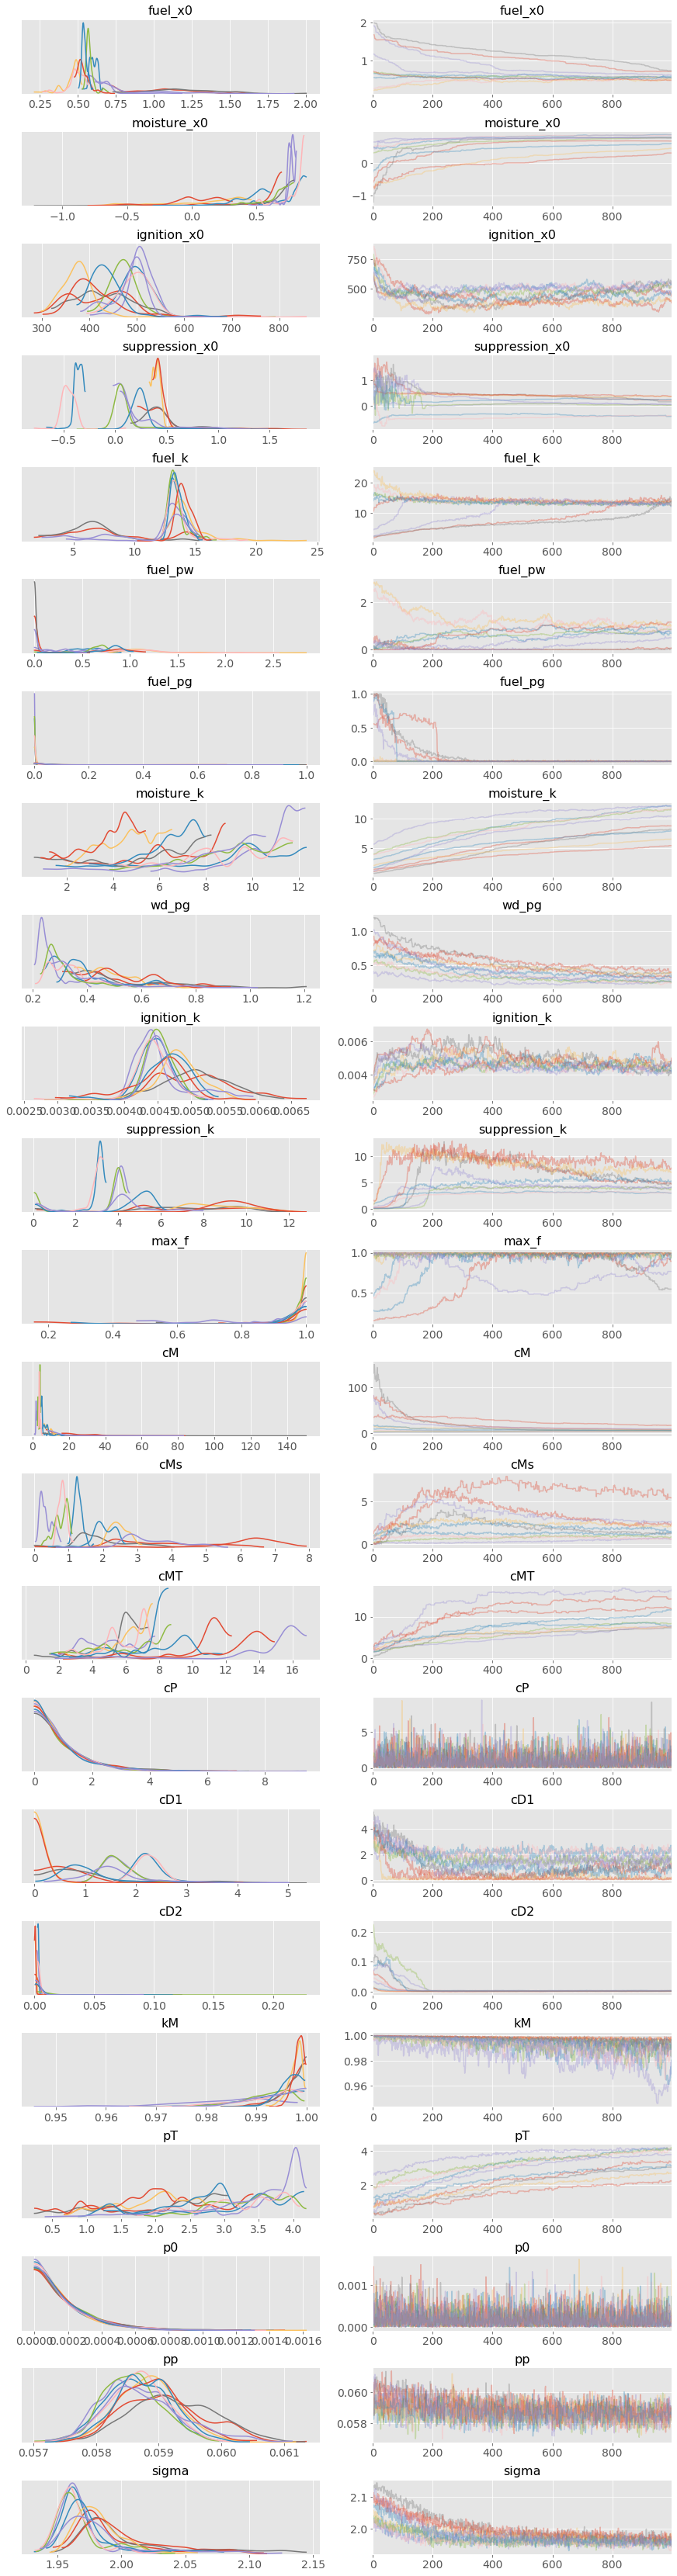

In [128]:
 
_ = pm3.traceplot(mcmc_traces[0:len(mcmc_traces[varnames[0]]):10], var_names = varnames)

On the right is how the parameter values evolve with each iteration. Each line is for each chain. You can probably see that some chains will look very different, emphasising the need to run multiple chains to properly sample to posterior. Also, some chains drift or jump around a lot at the start. This is cos it sometimes takes a bit of time for the optimization to settle down. Cos of this, we will just look at the last 1000 or so iterations to when assessing our posterior.

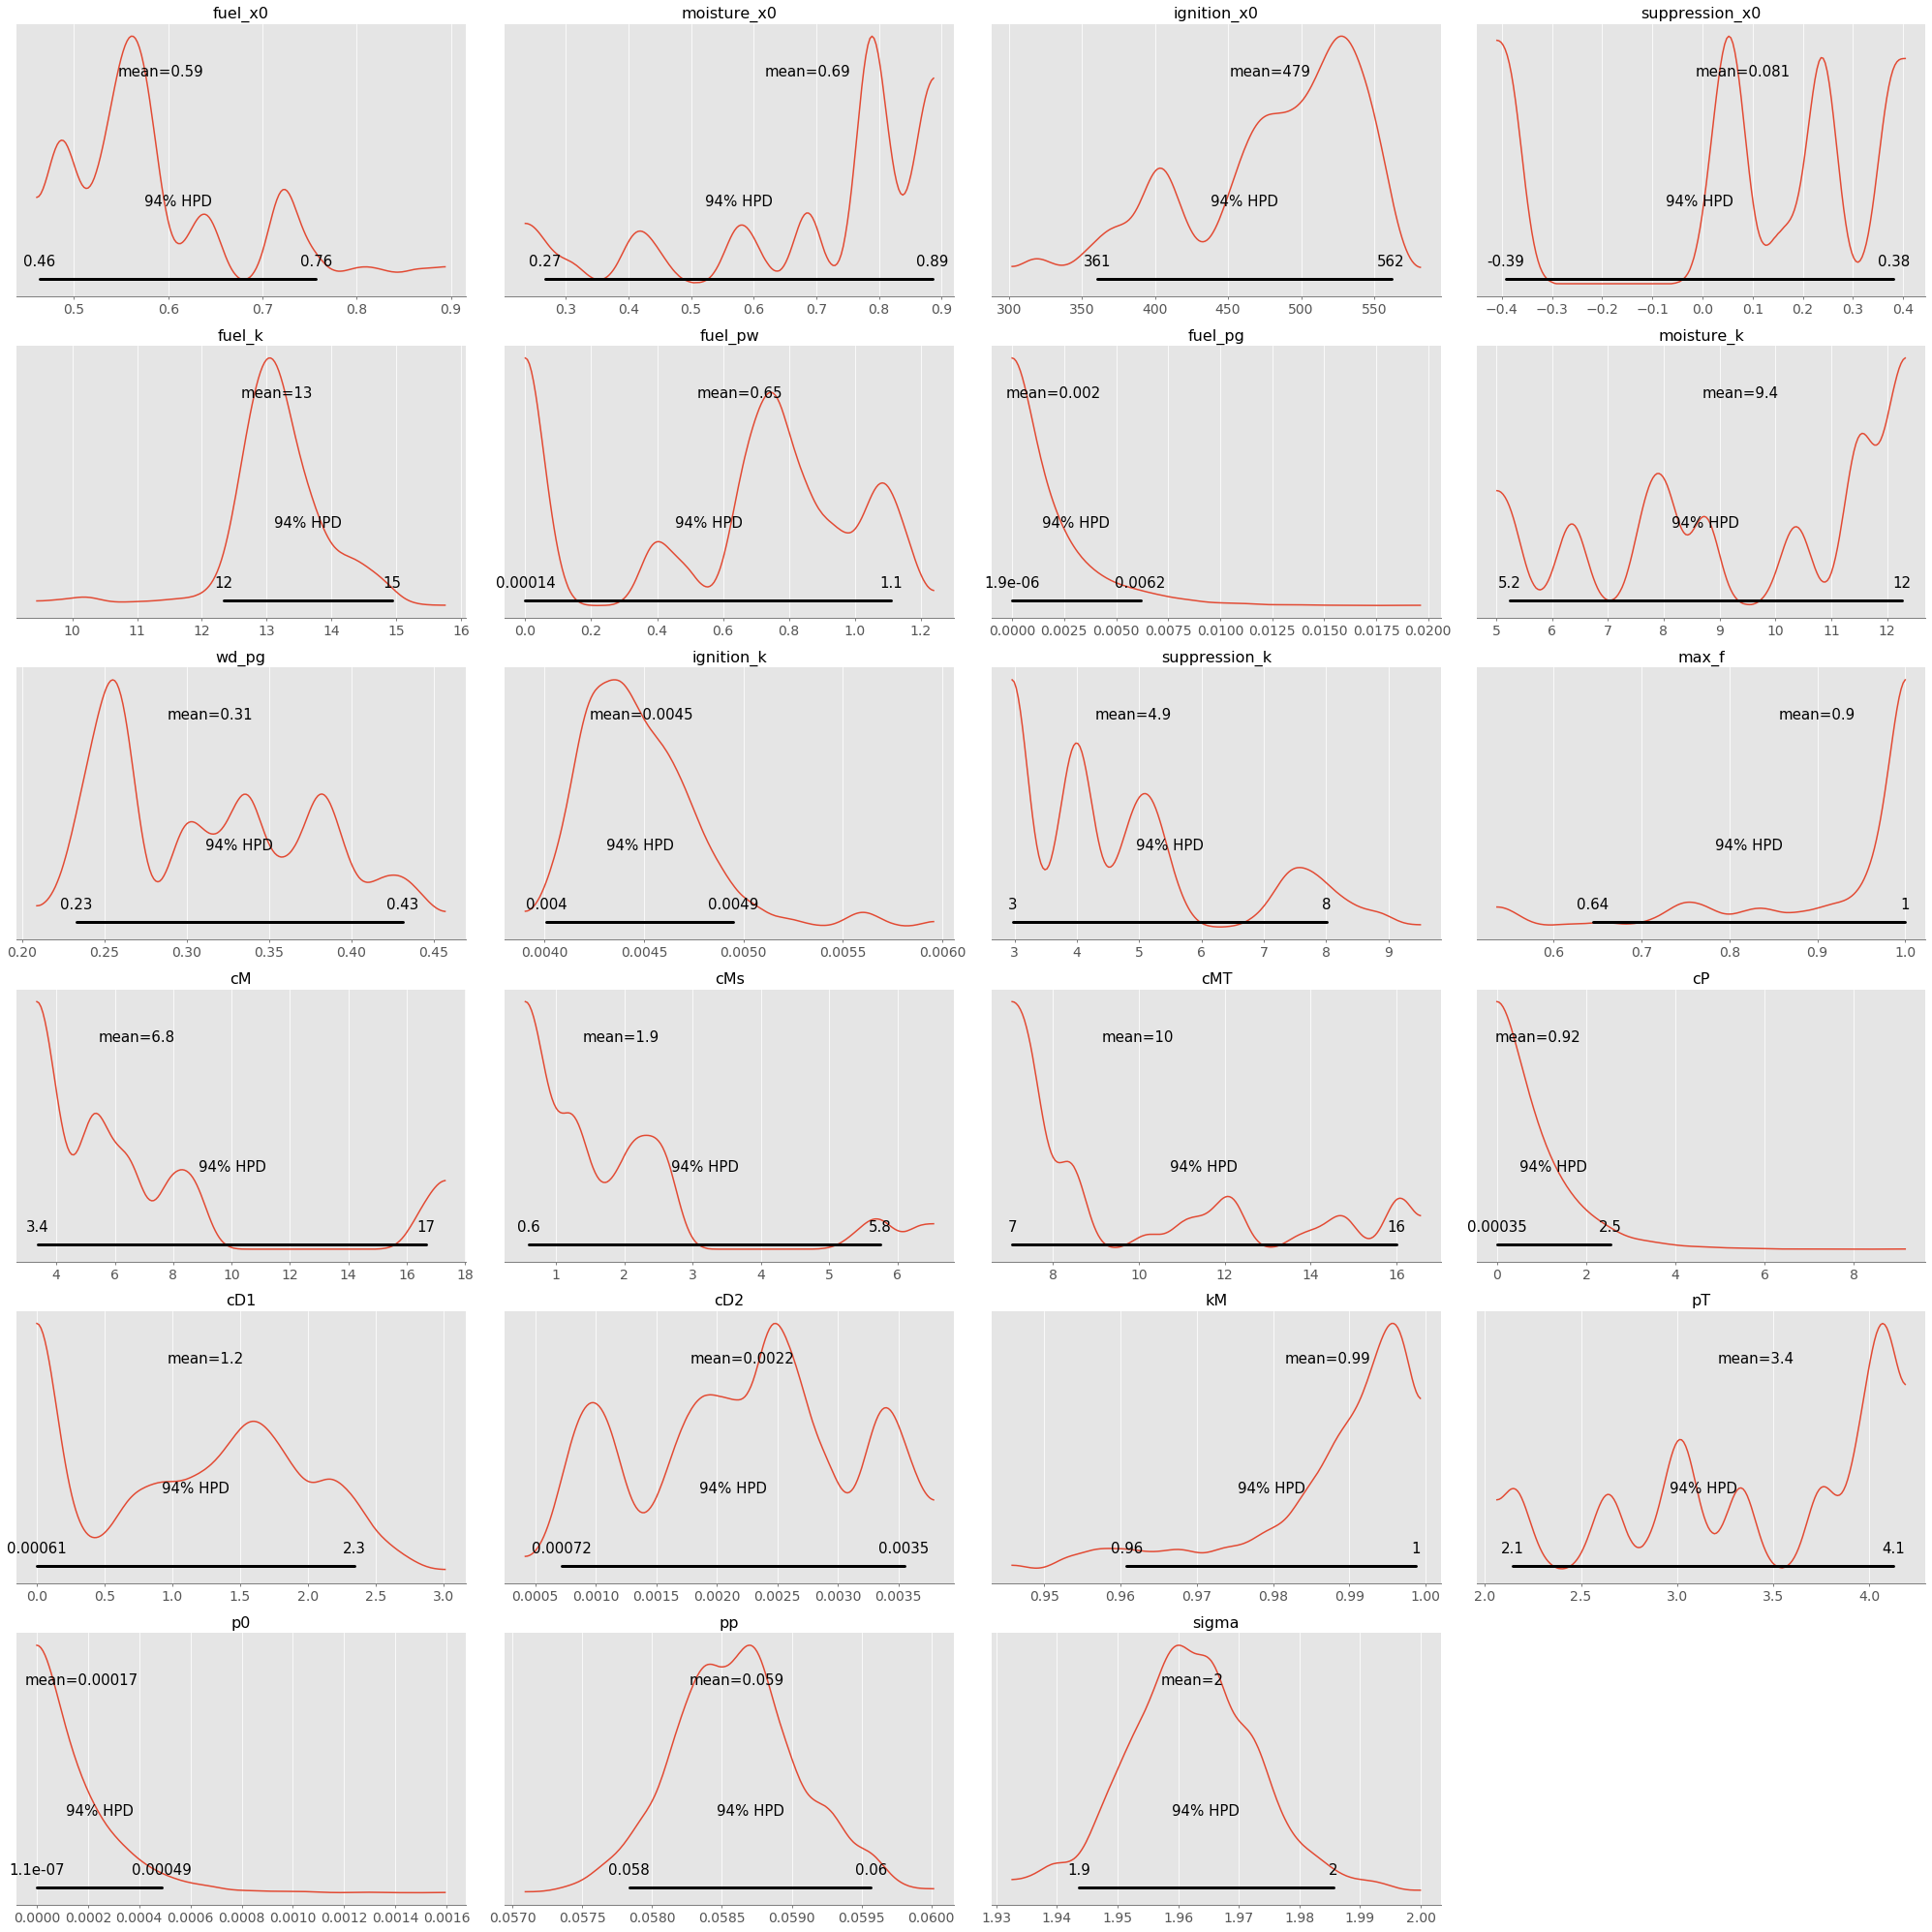

In [129]:
_ = pm3.plot_posterior(mcmc_traces[-1000:], var_names = varnames)

So this gives an idea of the posterior probability distribution of each parameter, but there is an important piece of information missing, namely how posterior distribution varies between parameters. Mapping out this full posterior solution is probably a bit much, but we can see how some keep key parameters vary with each other. Here, for example, x0 and k for each of our control curves.


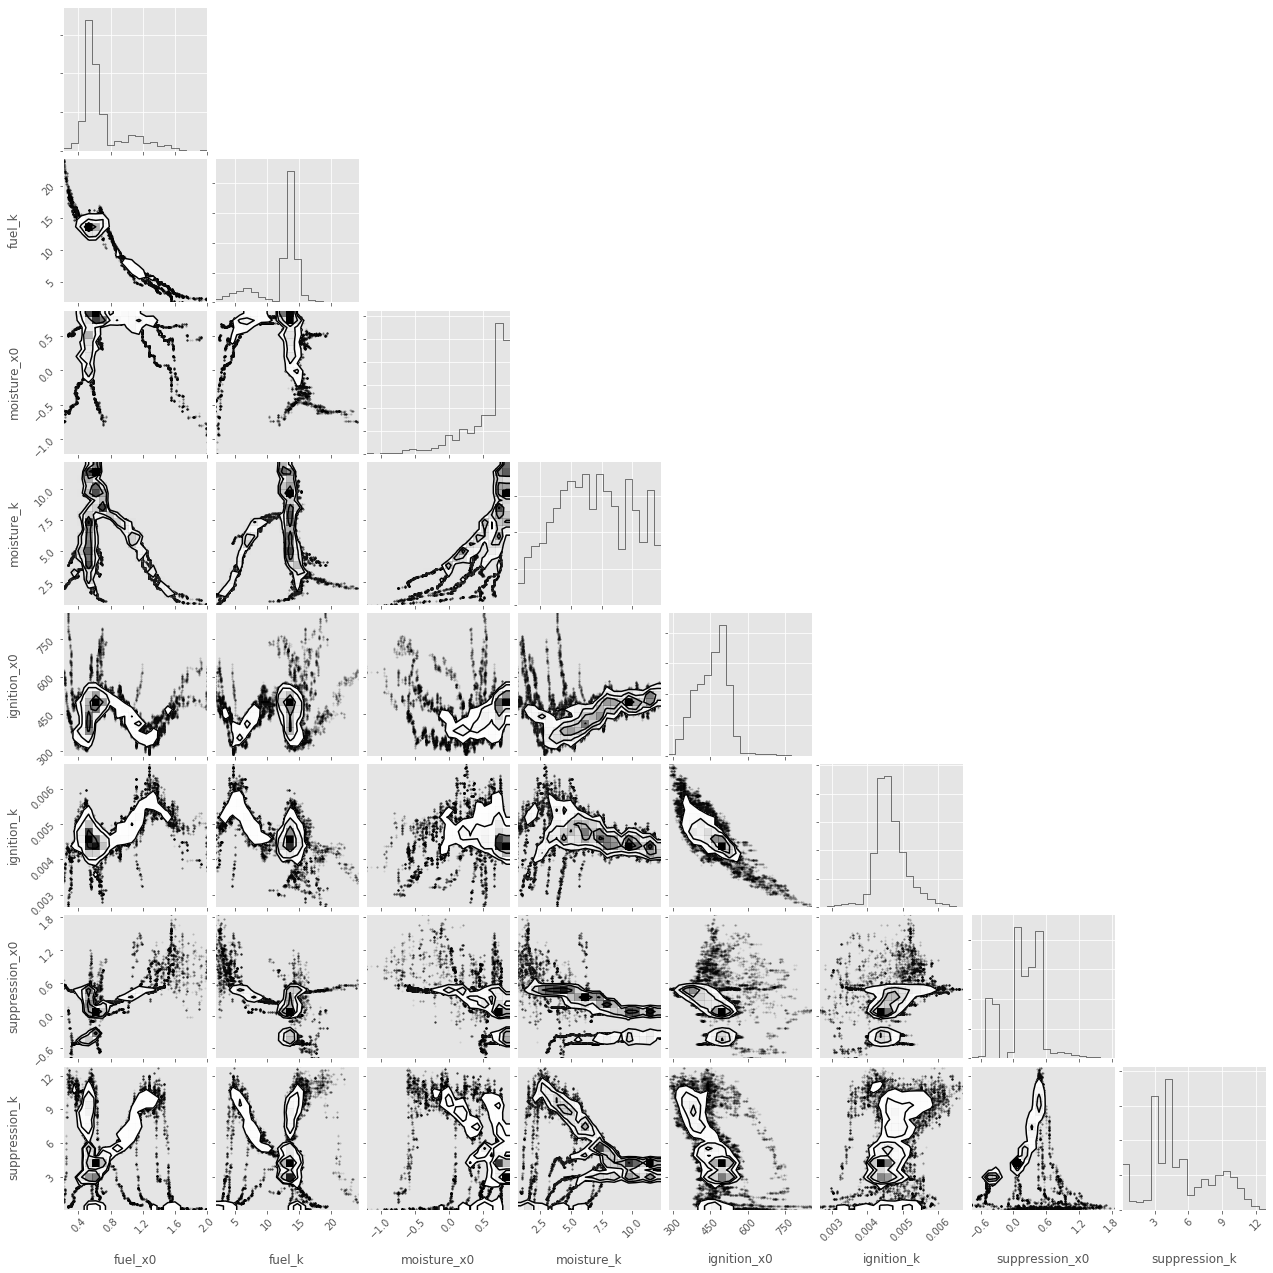

In [130]:
samples = pm3.trace_to_dataframe(mcmc_traces, varnames=['fuel_x0', 'fuel_k', 'moisture_x0', 'moisture_k',
                                                        'ignition_x0', 'ignition_k', 'suppression_x0', 'suppression_k'])
_ = corner.corner(samples)

## Output parameters
The iterations at the start are just letting the optimization settle. So we will only sample to last 50% of iterations for further analysis. We also export these to csv, which others can use to do their own analysis.


In [131]:
varnames = mcmc_traces.varnames
def cutLastX(varname, mcmc_traces, ncut = 50):
    vals = mcmc_traces.get_values(varname)
    def subcut(vals, r, ncut = 50):
        cut_np = (r+1) * round(len(vals)/nChains)
        ncut = round(len(vals) * ncut / (nChains *100))
        return vals[(cut_np - ncut):cut_np]
    vals = [subcut(vals, r) for r in range(nChains)]
    return np.array(vals).flatten()

vals = [cutLastX(i, mcmc_traces) for i in varnames]
vals = pd.DataFrame(np.array(vals).T, columns=varnames)
vals.to_csv(param_outpath, index=False)

 

I'll probably add some more interesting plots in the next couple of days. Though all the fancy maps are in the next notebook, ```make_model_output.ipynb```, which is the next notebook to head to.

<div>
<br>
<br>
<br>
<center>
<font size="5">
<a style="font-weight: bold; size: 5" href="http://localhost:8888/notebooks/notebooks/make_model_output.ipynb">Part 3: click here</a>
</font>
</center>
</div>